In [1]:
import sys
from simple_simulation_inverse_search import gates_set, matrix_list, add_inverse_gates
from simple_simulation_hardware import simple_compiler, simple_processor, single_simple_simulation
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simulation_test_run(num_gates_list, num_sample, add_FPGA_noise = True, t1 = None, t2 = None):
    fidelity_average = []
    fidelity_error = []
    for num_gates in num_gates_list:
        fidelity_list = [single_simple_simulation(
            num_gates, t1 = t1, t2 = t2, add_FPGA_noise = add_FPGA_noise
            ) for i in range(num_sample)]
        fidelity_average.append(np.mean(fidelity_list))
        fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    
    return fidelity_average, fidelity_error

In [5]:
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import ModelProcessor
from qutip import (sigmax, sigmay, tensor)

import functools # for reduce
from qutip.qip.operations.gates import *
from qutip import basis
from qutip_qip.circuit import QubitCircuit
from qutip.metrics import fidelity
from qutip.qip.noise import RandomNoise

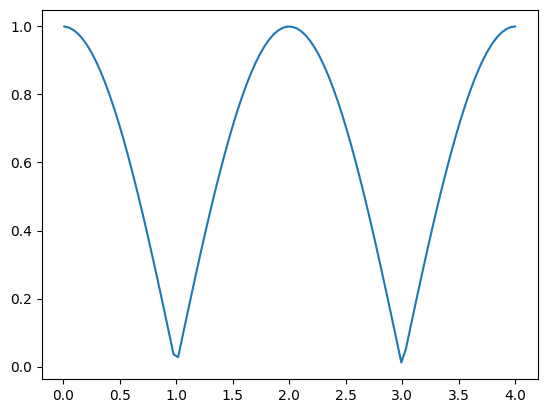

In [12]:
num_qubits =1
fidelity_list = []
index_list = []

for x in np.linspace(0.01,4,100):
    myprocessor = simple_processor(num_qubits)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 1})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    circuit.add_gate("RY", targets=0, arg_value=x*np.pi)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    
    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])

    fidelity_list.append(final_fidelity)
    index_list.append(x)

plt.plot(index_list,fidelity_list)

In [3]:
# For num_sample = 20, takes about 5 min
num_sample = 20
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,10)

In [4]:
fidelity_baseline, error_baseline = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = None, t2 = None)
fidelity_t1t2, error_t1t2 = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = 200, t2 = None)
fidelity_FPGA, error_FPGA = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = None, t2 = None)
fidelity_FPGA_t1t2, error_FPGA_t1t2 = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = 200, t2 = None)

KeyboardInterrupt: 

Text(0, 0.5, 'Ground State Fidelity')

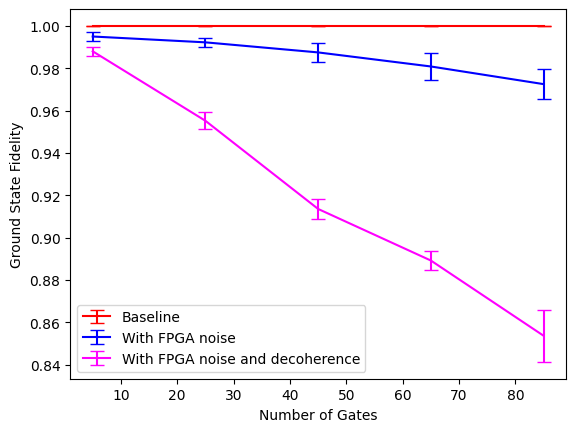

In [ ]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='blue', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='magenta', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")